In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
response = requests.get('https://www.kaggle.com/api/v1/datasets/download/jayeshx19/morning-routine-dataset')

datasetName='morning-routine-dataset.zip'
with open(datasetName, 'wb') as f:
    f.write(response.content)

df = pd.read_csv(datasetName)

print("Назви колонок: ", df.columns.tolist())
print("Розмір датасету: ", df.shape)


Назви колонок:  ['Date', 'Wake-up Time', 'Sleep Duration (hrs)', 'Meditation (mins)', 'Exercise (mins)', 'Breakfast Type', 'Journaling (Y/N)', 'Work Start Time', 'Productivity Score (1-10)', 'Mood', 'Notes']
Розмір датасету:  (900, 11)


In [8]:
print(df.isnull().sum())
dfClear = df.drop(columns=["Date", "Notes"])

Date                         0
Wake-up Time                 0
Sleep Duration (hrs)         0
Meditation (mins)            0
Exercise (mins)              0
Breakfast Type               0
Journaling (Y/N)             0
Work Start Time              0
Productivity Score (1-10)    0
Mood                         0
Notes                        0
dtype: int64


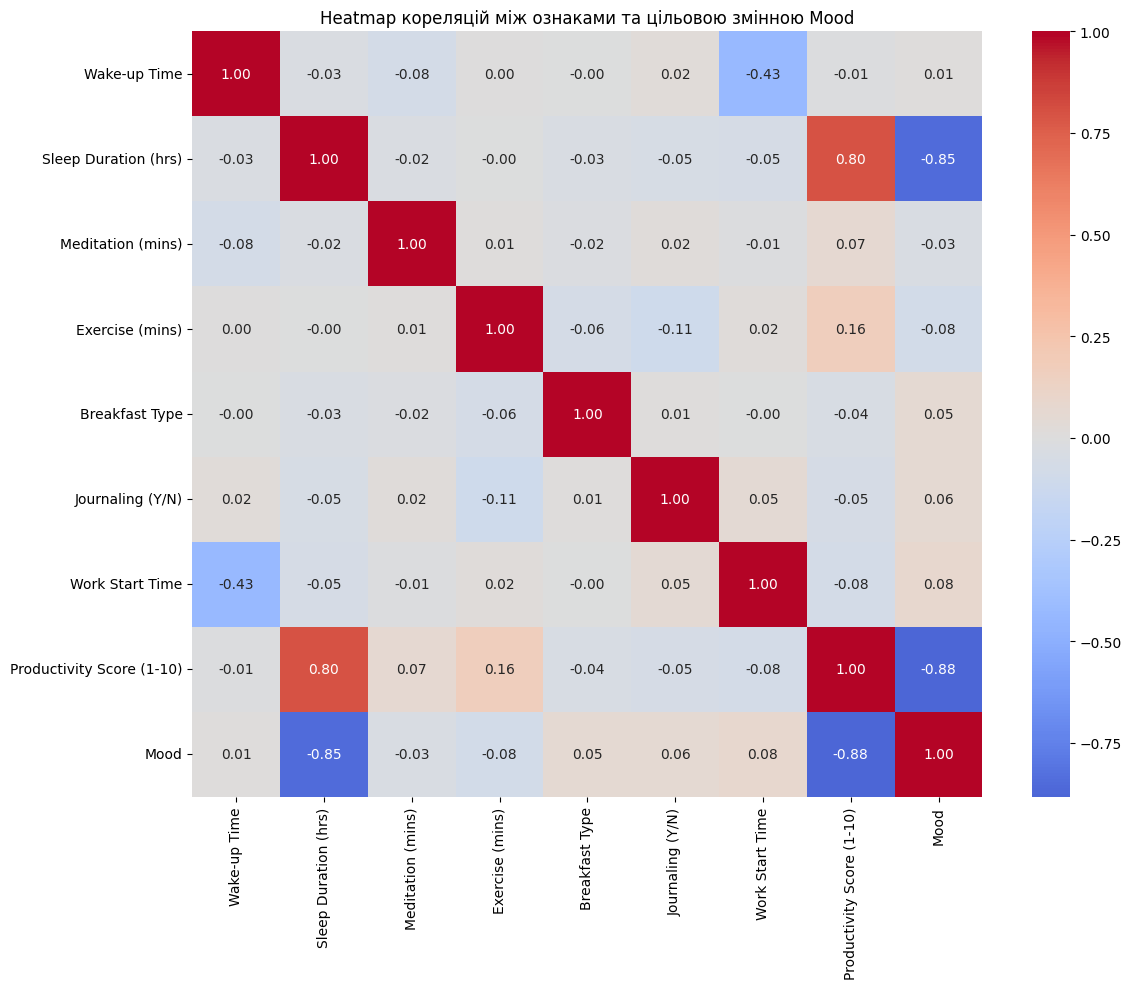

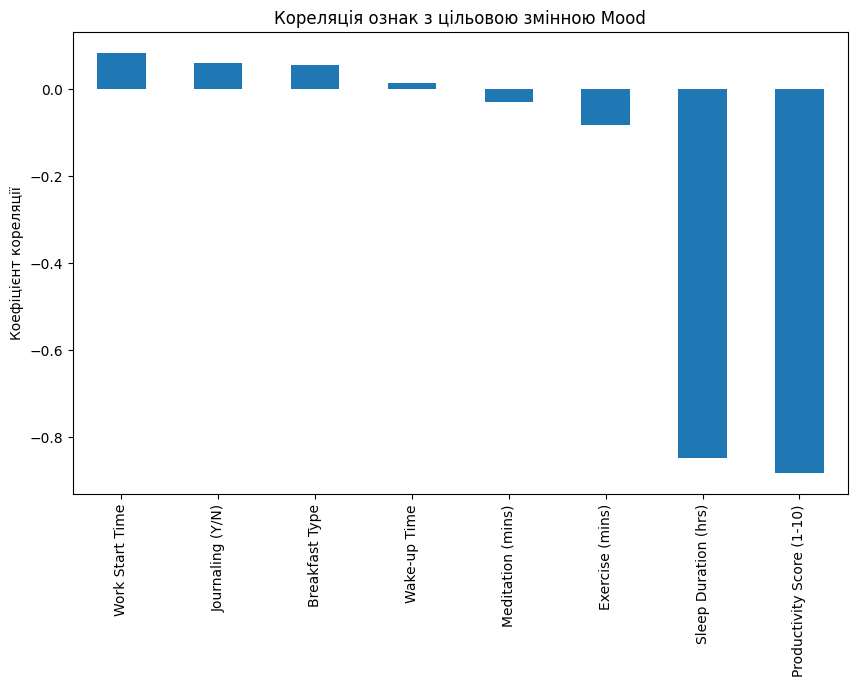

Гістограми розподілу ознак


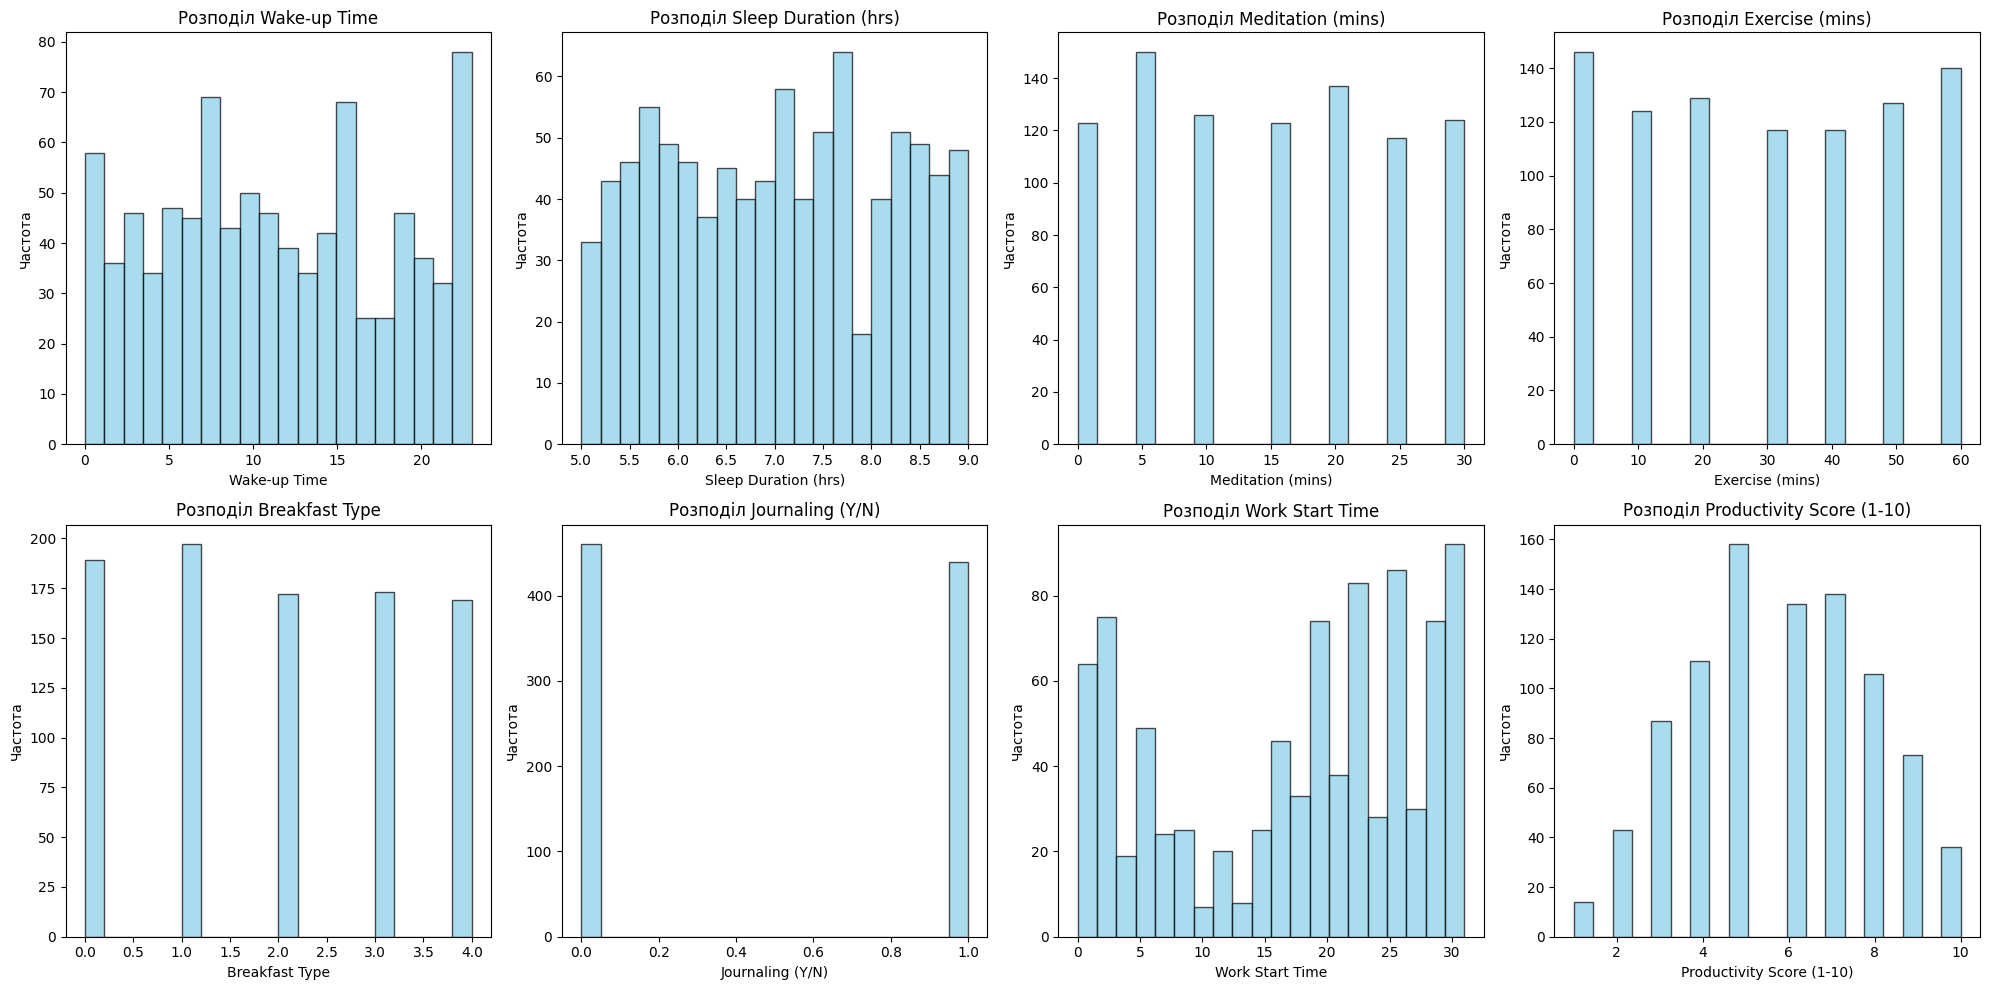

Розподіл цільової змінної Mood


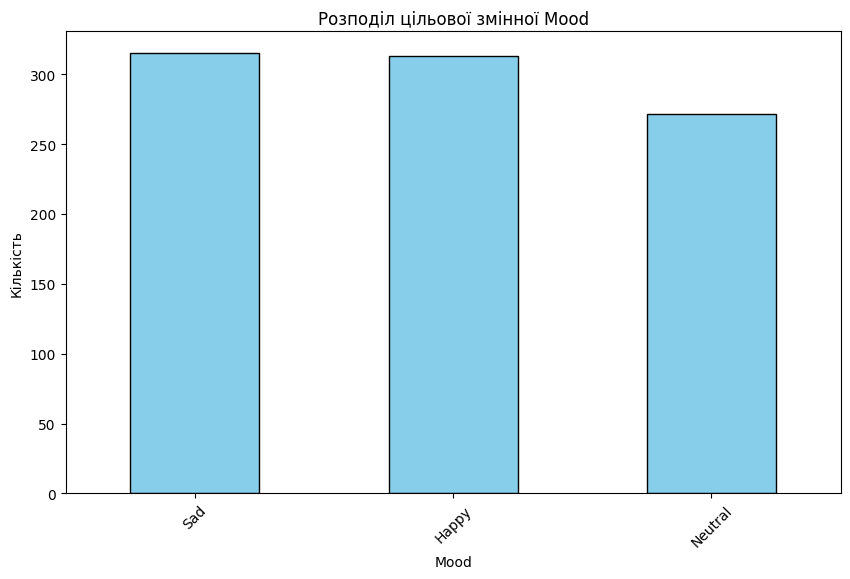

Boxplot-и ознак відносно цільової змінної


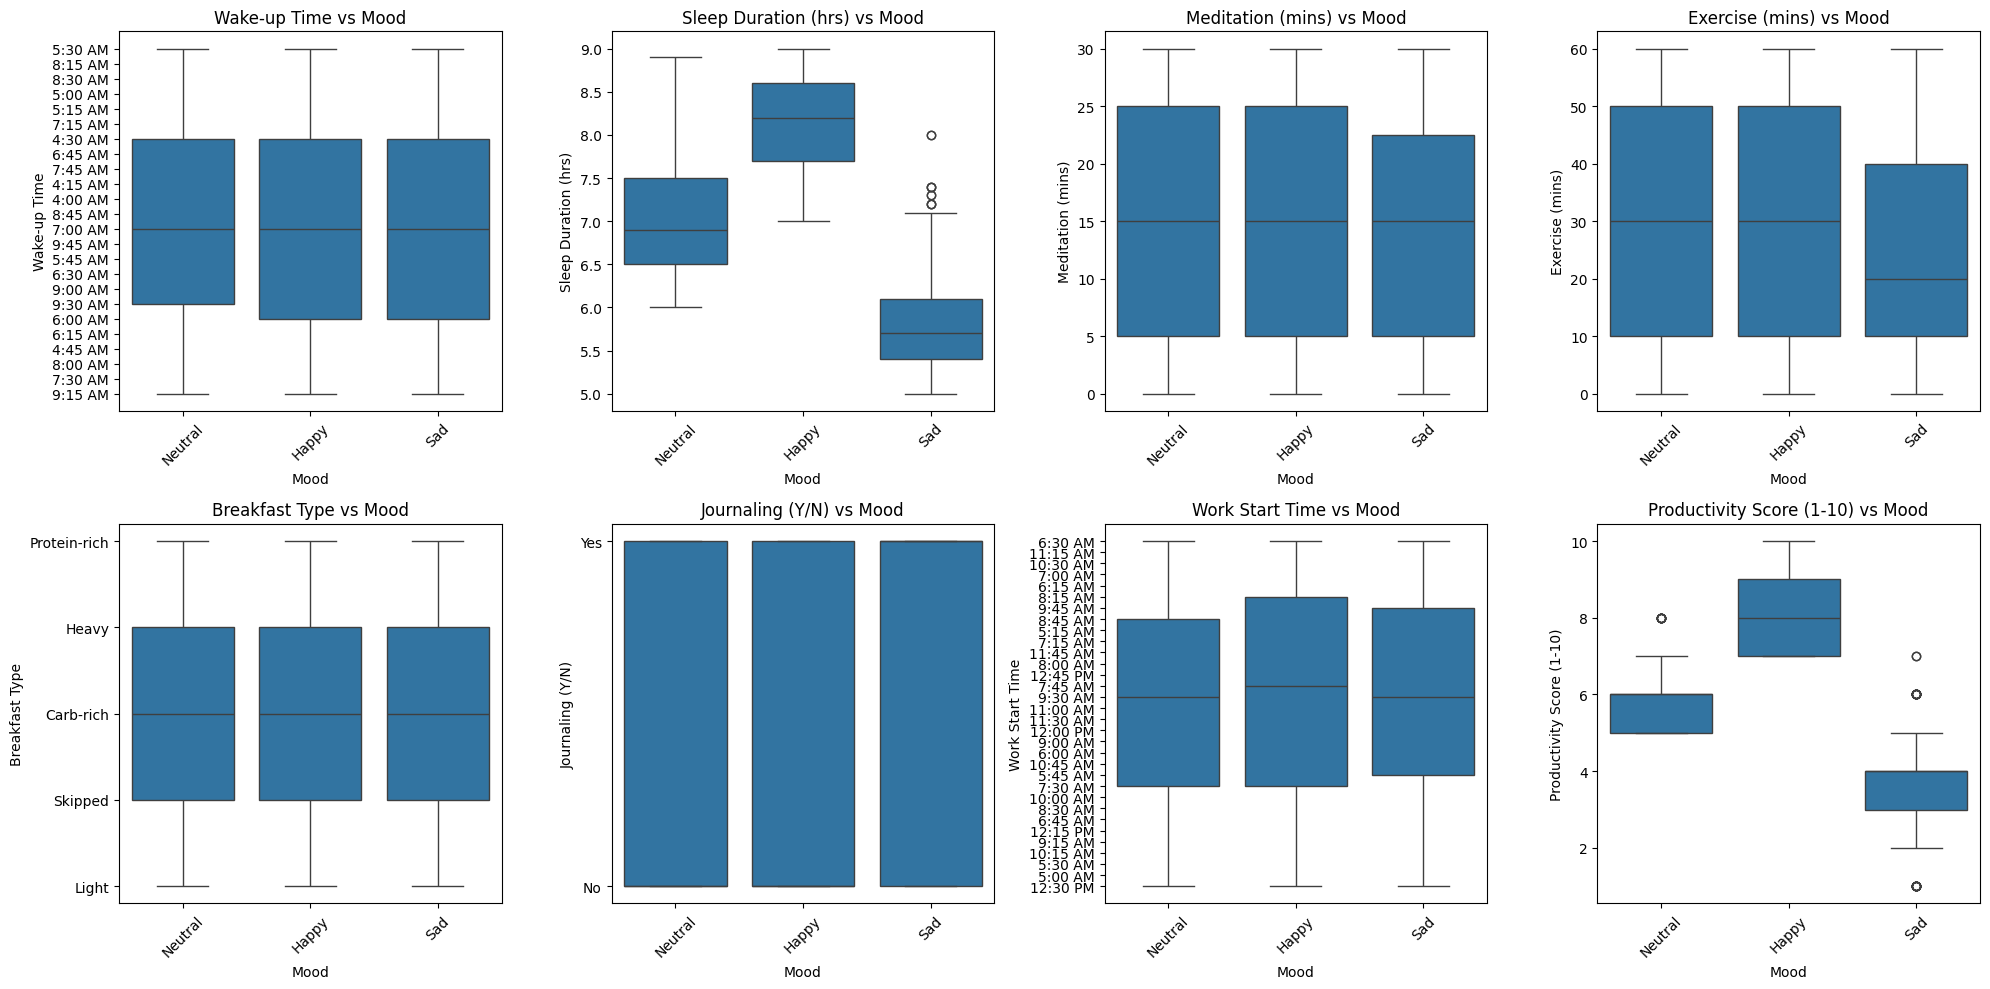

In [9]:
df_numeric = dfClear.copy()
le = LabelEncoder()
categorical_columns = df_numeric.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if col != 'Mood':
        df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))

df_numeric['Mood'] = le.fit_transform(df_numeric['Mood'])

plt.figure(figsize=(12, 10))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Heatmap кореляцій між ознаками та цільовою змінною Mood')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
mood_correlations = correlation_matrix['Mood'].drop('Mood').sort_values(ascending=False)
mood_correlations.plot(kind='bar')
plt.title('Кореляція ознак з цільовою змінною Mood')
plt.ylabel('Коефіцієнт кореляції')
plt.show()

print("Гістограми розподілу ознак")
feature_columns = [col for col in df_numeric.columns if col != 'Mood']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(feature_columns):
    axes[i].hist(df_numeric[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Розподіл {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

for j in range(len(feature_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

print("Розподіл цільової змінної Mood")
plt.figure(figsize=(10, 6))
dfClear['Mood'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Розподіл цільової змінної Mood')
plt.xlabel('Mood')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.show()

print("Boxplot-и ознак відносно цільової змінної")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(feature_columns):
    df_boxplot = dfClear.copy()
    df_boxplot['Mood_numeric'] = df_numeric['Mood']
    sns.boxplot(data=df_boxplot, x='Mood', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs Mood')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(feature_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



In [11]:
print("Нормалізація даних:")

X = df_numeric.drop('Mood', axis=1)
y = df_numeric['Mood']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Розмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

Нормалізація даних:
Розмір тренувальної вибірки: (720, 8)
Розмір тестової вибірки: (180, 8)


=== kNN ===
Найкращі параметри: {'n_neighbors': 12}
Точність на тренувальних даних: 0.8556
Classification Report для kNN:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        63
           1       0.72      0.61      0.66        54
           2       0.89      0.86      0.87        63

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

Confusion Matrix для kNN:
[[59  4  0]
 [14 33  7]
 [ 0  9 54]]


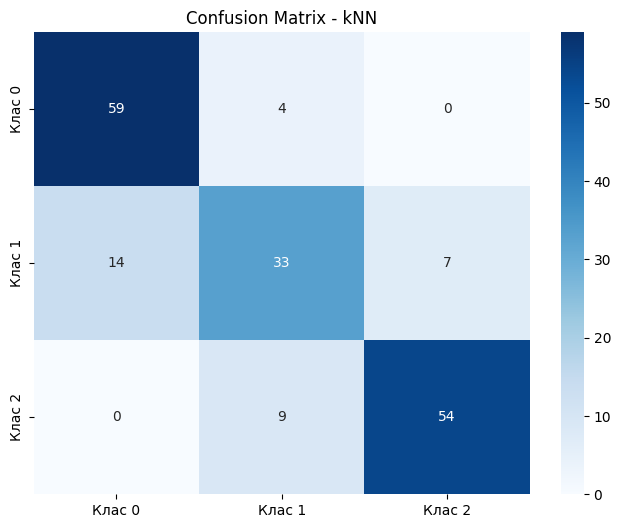

In [15]:
best_models = {}

print("=== kNN ===")
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(1, 20)}
knn_grid = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_
best_models['kNN'] = best_knn

print(f"Найкращі параметри: {knn_grid.best_params_}")
print(f"Точність на тренувальних даних: {knn_grid.best_score_:.4f}")

y_pred_knn = best_knn.predict(X_test)
print("Classification Report для kNN:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix для kNN:")
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)



plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Клас 0', 'Клас 1', 'Клас 2'],
            yticklabels=['Клас 0', 'Клас 1', 'Клас 2'])
plt.title('Confusion Matrix - kNN')
plt.show()

=== Decision Tree ===
Найкращі параметри: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Точність на тренувальних даних: 1.0000
Classification Report для Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       0.96      1.00      0.98        54
           2       1.00      0.97      0.98        63

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Confusion Matrix для Decision Tree:
[[63  0  0]
 [ 0 54  0]
 [ 0  2 61]]


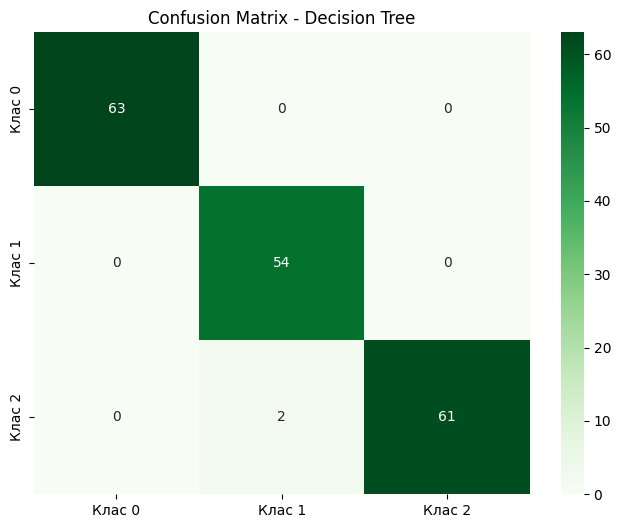

In [16]:
print("=== Decision Tree ===")
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
best_models['Decision Tree'] = best_dt

print(f"Найкращі параметри: {dt_grid.best_params_}")
print(f"Точність на тренувальних даних: {dt_grid.best_score_:.4f}")

y_pred_dt = best_dt.predict(X_test)
print("Classification Report для Decision Tree:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix для Decision Tree:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Клас 0', 'Клас 1', 'Клас 2'],
            yticklabels=['Клас 0', 'Клас 1', 'Клас 2'])
plt.title('Confusion Matrix - Decision Tree')
plt.show()

=== SVM ===
Найкращі параметри: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Точність на тренувальних даних: 0.9486
Classification Report для SVM:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        63
           1       0.87      0.89      0.88        54
           2       0.95      0.94      0.94        63

    accuracy                           0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180

Confusion Matrix для SVM:
[[60  3  0]
 [ 3 48  3]
 [ 0  4 59]]


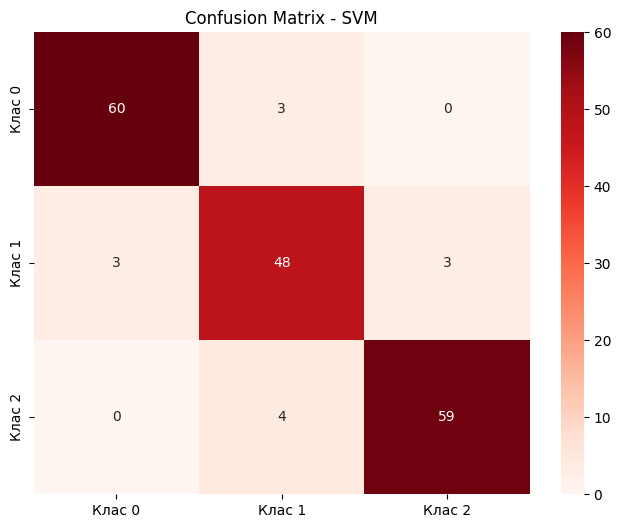

In [17]:
print("=== SVM ===")
svm = SVC(random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
best_models['SVM'] = best_svm

print(f"Найкращі параметри: {svm_grid.best_params_}")
print(f"Точність на тренувальних даних: {svm_grid.best_score_:.4f}")

y_pred_svm = best_svm.predict(X_test)
print("Classification Report для SVM:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix для SVM:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Клас 0', 'Клас 1', 'Клас 2'],
            yticklabels=['Клас 0', 'Клас 1', 'Клас 2'])
plt.title('Confusion Matrix - SVM')
plt.show()


=== Random Forest ===
Найкращі параметри: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Точність на тренувальних даних: 1.0000
Classification Report для Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       0.96      1.00      0.98        54
           2       1.00      0.97      0.98        63

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Confusion Matrix для Random Forest:
[[63  0  0]
 [ 0 54  0]
 [ 0  2 61]]


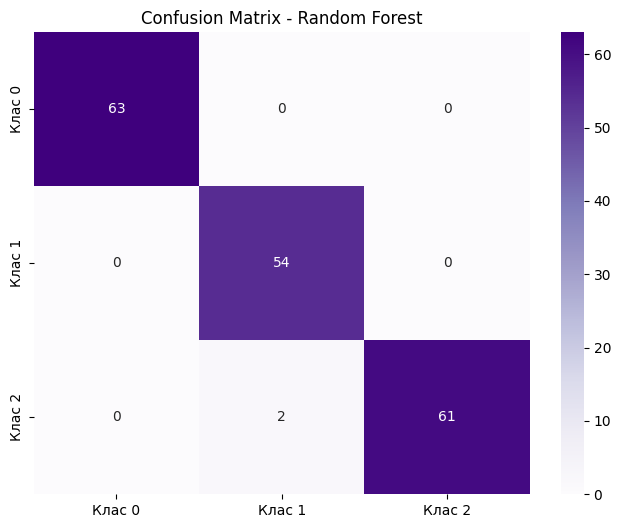

In [19]:
print("=== Random Forest ===")
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
best_models['Random Forest'] = best_rf

print(f"Найкращі параметри: {rf_grid.best_params_}")
print(f"Точність на тренувальних даних: {rf_grid.best_score_:.4f}")

y_pred_rf = best_rf.predict(X_test)
print("Classification Report для Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix для Random Forest:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Клас 0', 'Клас 1', 'Клас 2'],
            yticklabels=['Клас 0', 'Клас 1', 'Клас 2'])
plt.title('Confusion Matrix - Random Forest')
plt.show()

=== AdaBoost ===
Найкращі параметри: {'learning_rate': 1.0, 'n_estimators': 50}
Точність на тренувальних даних: 1.0000
Classification Report для AdaBoost:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        63
           1       1.00      1.00      1.00        54
           2       1.00      0.97      0.98        63

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Confusion Matrix для AdaBoost:
[[63  0  0]
 [ 0 54  0]
 [ 2  0 61]]


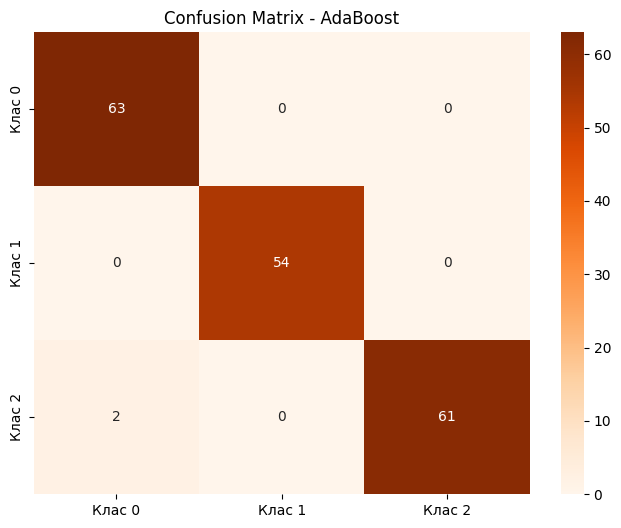

In [20]:
print("=== AdaBoost ===")
ada = AdaBoostClassifier(random_state=42)
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada_grid = GridSearchCV(ada, param_grid_ada, cv=5, scoring='accuracy')
ada_grid.fit(X_train, y_train)
best_ada = ada_grid.best_estimator_
best_models['AdaBoost'] = best_ada

print(f"Найкращі параметри: {ada_grid.best_params_}")
print(f"Точність на тренувальних даних: {ada_grid.best_score_:.4f}")

y_pred_ada = best_ada.predict(X_test)
print("Classification Report для AdaBoost:")
print(classification_report(y_test, y_pred_ada))
print("Confusion Matrix для AdaBoost:")
cm_ada = confusion_matrix(y_test, y_pred_ada)
print(cm_ada)

# ВІЗУАЛІЗАЦІЯ CONFUSION MATRIX ДЛЯ AdaBoost
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Клас 0', 'Клас 1', 'Клас 2'],
            yticklabels=['Клас 0', 'Клас 1', 'Клас 2'])
plt.title('Confusion Matrix - AdaBoost')
plt.show()

           Model  Accuracy
1  Decision Tree  0.988889
4       AdaBoost  0.988889
3  Random Forest  0.988889
2            SVM  0.927778
0            kNN  0.811111


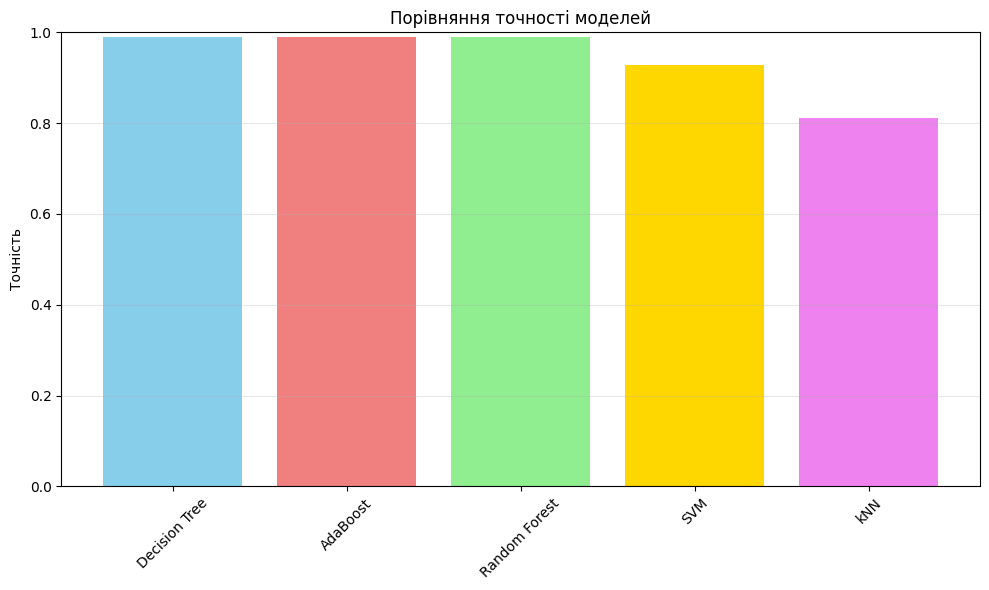

In [21]:
model_comparison = []
for name, model in best_models.items():
    accuracy = model.score(X_test, y_test)
    model_comparison.append({'Model': name, 'Accuracy': accuracy})

comparison_df = pd.DataFrame(model_comparison).sort_values('Accuracy', ascending=False)
print(comparison_df)

plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Model'], comparison_df['Accuracy'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet'])
plt.title('Порівняння точності моделей')
plt.ylabel('Точність')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()